# Estimating R0- Summer School 17 Exercise- Lecture 4

# Libraries

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import matplotlib.ticker as plticker
import numpy as np
from matplotlib import rc #for latex use on the plots
from matplotlib import ticker  # for labels formattings
import sklearn
%matplotlib inline
from sklearn import linear_model
from scipy.optimize import minimize
from scipy.integrate import odeint
from os import getcwd,path
from numpy import pi
from scipy.special import factorial
from scipy.stats import poisson

# Plot configs

In [13]:
plt.style.use('ggplot')
perso_linewidth = 0.6
# This will change your default rcParams
def init_plotting():
    plt.rcParams['figure.figsize'] = (40,20)
    plt.rcParams['font.size'] = 30
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['axes.titlesize'] = 1.5*plt.rcParams['font.size']
    plt.rcParams['legend.fontsize'] = plt.rcParams['font.size']
    plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
    #plt.rcParams['savefig.dpi'] = 2*plt.rcParams['savefig.dpi']
    plt.rcParams['axes.linewidth'] = perso_linewidth
    plt.rcParams['savefig.dpi'] = '300'
    plt.rcParams['savefig.format'] = 'pdf'
    plt.rcParams['axes.facecolor'] = '#D3D3D3'
    plt.rcParams['axes.edgecolor'] = '0'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.color']='white'
    plt.rcParams['grid.linestyle'] = '-'
    plt.rcParams['grid.linewidth'] = '0.4'
    plt.rcParams['axes.axisbelow'] = True
    plt.rcParams['legend.edgecolor'] = 'black'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['lines.markersize']= 18 
    plt.rcParams['lines.markeredgewidth']= '0.1'
    plt.rcParams['lines.color']= 'r' 
    plt.rcParams['lines.marker']= 'o' 
    plt.rcParams['lines.linestyle']= '-' 
    plt.rcParams['xtick.color']= '0'
    plt.rcParams['ytick.color']= '0'
    #plt.rcParams['axes.color_cycle']= ['#3778bf', '#feb308', '#a8a495', '#7bb274', '#825f87']
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['right'].set_visible('False')
    plt.gca().spines['top'].set_visible('False')
    plt.gca().spines['top'].set_color('none')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('left')
    plt.rcParams['ytick.minor.size']= 1.5
    plt.rcParams['ytick.major.width']= perso_linewidth
    plt.rcParams['ytick.minor.width']= perso_linewidth
    plt.rcParams['xtick.major.width']= perso_linewidth
    plt.rcParams['xtick.minor.width']= perso_linewidth

init_plotting()

plt.close() # this line to avoid an empty plot showing up

### Centering the plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Epidemic in a british boarding school

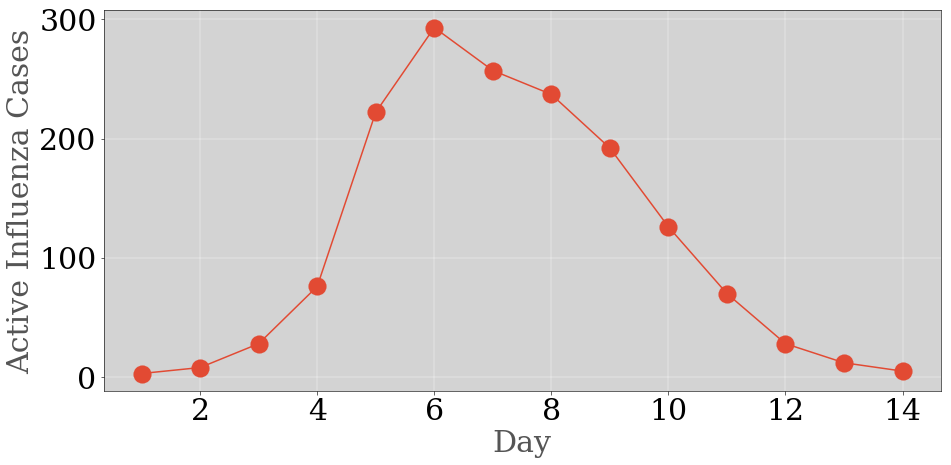

In [14]:
csv_file_path=path.join(getcwd(), 'data','Boarding.csv')
df=pd.read_csv(csv_file_path,index_col=0,header=0)
fig1=plt.figure(figsize=(15,7))
ax1=plt.subplot(111)
plt.plot(df.day,df.flu,marker='o')
plt.xlabel('Day')
plt.ylabel('Active Influenza Cases')
plt.show()

### Excersie 1

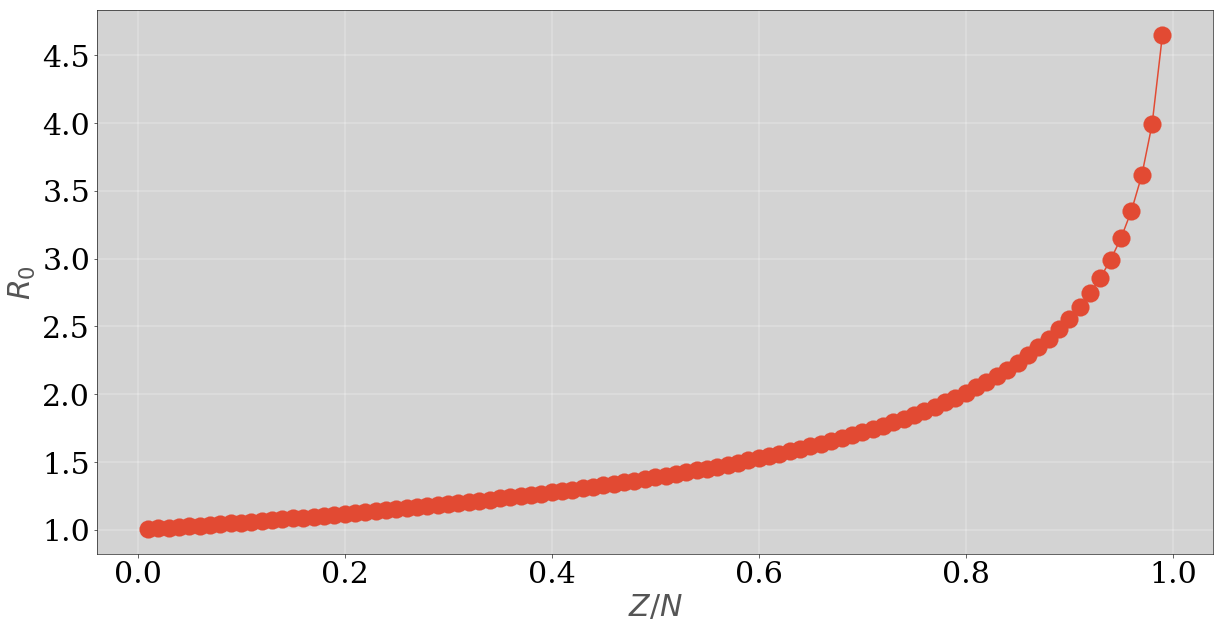

In [15]:
size=np.arange(0.01,1.0,0.01)  ## size (final outbreak size)=Z/N, Z=Infected individuals at the end of an outbreak, N total population
R_0=np.log(1-size)/(-size)
fig2=plt.figure(figsize=(20,10))
ax2=plt.subplot(111)
plt.plot(size,R_0)
plt.xlabel('$Z/N$')
plt.ylabel('$R_0$')
plt.show()

### Excersice 2

In [16]:
Gamma=1/1 ### change infectious period from 2.5 days to 1 day
x=df.day[:4].values.reshape(-1,1)
y=np.log(df.flu[:4].values).reshape(-1,1)

reg=linear_model.LinearRegression()
reg.fit(x,y)
coef=reg.coef_
R_0=(coef/Gamma)+1
R_0

array([[2.09491261]])

### Exercise 3

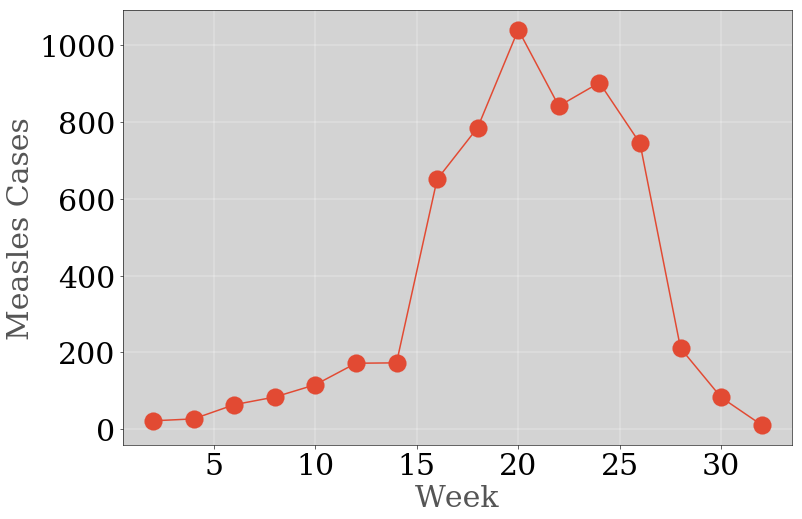

In [17]:
df2=pd.read_csv('data/niamey.csv',index_col=0,header=0)
fig=plt.figure(figsize=(12,8))
ax=plt.subplot(111)
plt.plot(df2.index*2,df2.V1,marker='o')
plt.xlabel('Week')
plt.ylabel('Measles Cases')
plt.show()

### SIR function

In [18]:
def SIR(state,t,Beta,Gamma):   #### in this example S,I and R are numbers; not fractions
    S,I,R=state
    dS=-Beta*S*I
    dI=(Beta*S*I-Gamma*I)
    dR=Gamma*I
    return dS,dI,dR
# def SIR2(state,t):   #### in this example S,I and R are numbers; not fractions
#     S,I,R,Beta,Gamma=state
#     dS=-Beta*S*I
#     dI=(Beta*S*I-Gamma*I)
#     dR=Gamma*I
#     return dS,dI,dR

# SSE

### Objective function

In [19]:
def obj(params,Y,fixed_gamma):
    beta,gamma,s0,i0,r0=params
    t_Y=(Y.index.values-1)*(14/365)
    
    if any(params<0):
        sse=1e9
        return sse
    #### Overridden values
    r0=0
    if fixed_gamma==1:
        gamma=365/13
    
    size=len(Y)
    
    t_end=(Y.index[-1]-1)*(14/365)
    dt=(14/365)*0.2
    T=np.linspace(0,t_end,size)

    initial_state=[s0,i0,r0]
    sol = odeint(SIR, initial_state,T,args=(beta,gamma))
    I=sol[:,1]
    
    diff=Y-np.interp(t_Y,T,I)
    sse=sum(diff**2)
    return sse   

## Optimization - fixed $\gamma$ 

In [20]:
beta=0.04076
gamma=365/13
s0=1480
i0=1
r0=0.0
initial=[beta,gamma,s0,i0,r0]


res=minimize(obj,initial,args=(df2.V1,1),method="Nelder-Mead",options={'maxiter': 20000,'maxfev':20000,'fatol':0.001})

#bnds = ((0.0, None), (0, None),(0,1),(0,1))
#res=minimize(obj,x0,args=(y_reported,dt),method='Nelder-Mead', options={'maxiter':10000, 'maxfev': 10000})

### Plotting Results

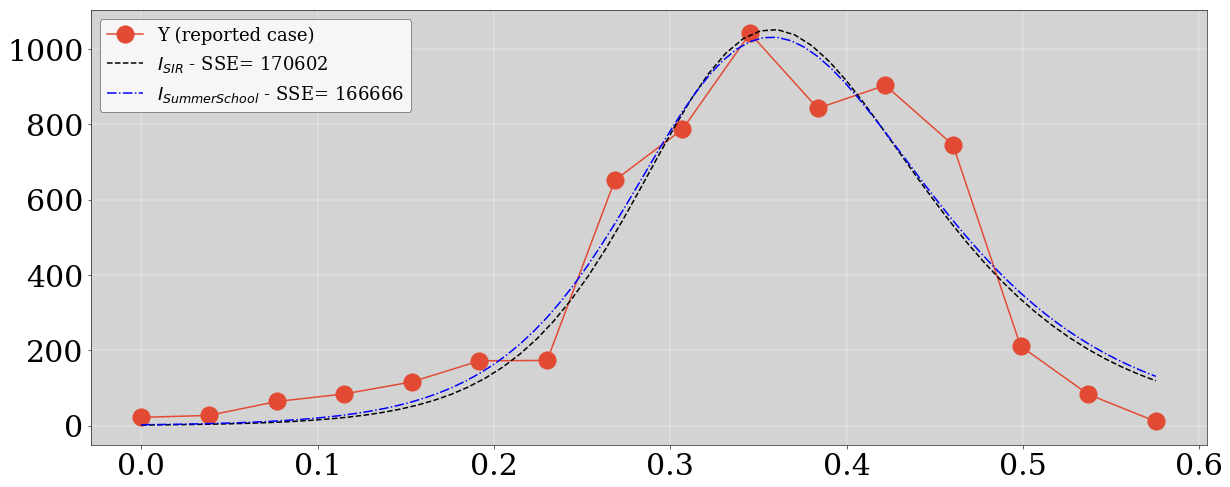

In [21]:
### Case count
Y=df2.V1
t_Y=(df2.index-1)*(14/365)


#############
####################
##############################

###### Optim. results
beta,gamma,s0,i0,r0=res.x

# Overridden Values
r0=0
gamma=365/13

t_end=(df2.V1.index[-1]-1)*(14/365)
T=np.linspace(0,t_end,60)

initial_state=[s0,i0,r0]
sol = odeint(SIR, initial_state,T,args=(beta,gamma))
S=sol[:,0]
I=sol[:,1]
R=sol[:,2]

ssd1=int(res.fun)


###############
#################
####################

# Summer School Result

beta=5.463181e-3
gamma=365/13
s_initial=9.110385e3
i_initial=2.331841
r_initial=0

dt2=(14/365)*0.2
T2=np.arange(0,t_end+dt2,dt2)

initial_state=[s_initial,i_initial,r_initial]
sol = odeint(SIR, initial_state,T2,args=(beta,gamma))
S2=sol[:,0]
I2=sol[:,1]
R2=sol[:,2]


diff2=Y-np.interp(t_Y,T2,I2)
ssd2=int(sum(diff2**2))

#############
###################
###########################

#### Plots

fig=plt.figure(figsize=(20,8))
ax=plt.subplot(111)
plt.plot(t_Y,Y,marker='o',label='Y (reported case)')
plt.plot(T,I,'--k',label='$I_{SIR}$ - SSE= '+str(ssd1))
plt.plot(T2,I2,'-.b',label='$I_{Summer School}$ - SSE= '+str(ssd2))
plt.legend(fontsize=18)

## Optimization- variable $\gamma$

In [22]:
beta=0.04076
gamma=365/13
s0=1480
i0=1
r0=0.0
initial=[beta,gamma,s0,i0,r0]


res_BFGS=minimize(obj,initial,args=(df2.V1,0),method="BFGS",options={'maxiter': 40000,'maxfev':40000,'fatol':0.001},tol=0.001)
res_Nelder_Mead=minimize(obj,initial,args=(df2.V1,0),method="Nelder-Mead",options={'maxiter': 40000,'maxfev':40000,'fatol':0.001},tol=0.001)

C:\Users\arashs\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:9: OptimizeWarning: Unknown solver options: maxfev, fatol


### Comparing optimization algorithms
\begin{itemize}
\item \textbf{Nelder-Mead}: min(SSE)= 194e3
\item Powell: min(SSE)= 339e3
\item CG: Does not converge
\item \textbf{BFGS}: min(SSE)=165e3
\item Newton-CG: Needs Jacobian
\item L-BFGS-B: min(SSE)=3.17e6
\item TNC: min(SSE)= 296e3
\item COBYLA: min(SSE)=322e3
\item SLSQP: wierd flat line
\item Dogleg: needs Jacobian
\item trust-ncg: needs Jacobian
\item trust-exact: Unknow solver!
\item trust-krylov: Unknow solver
\end{itemize}

### Plotting results

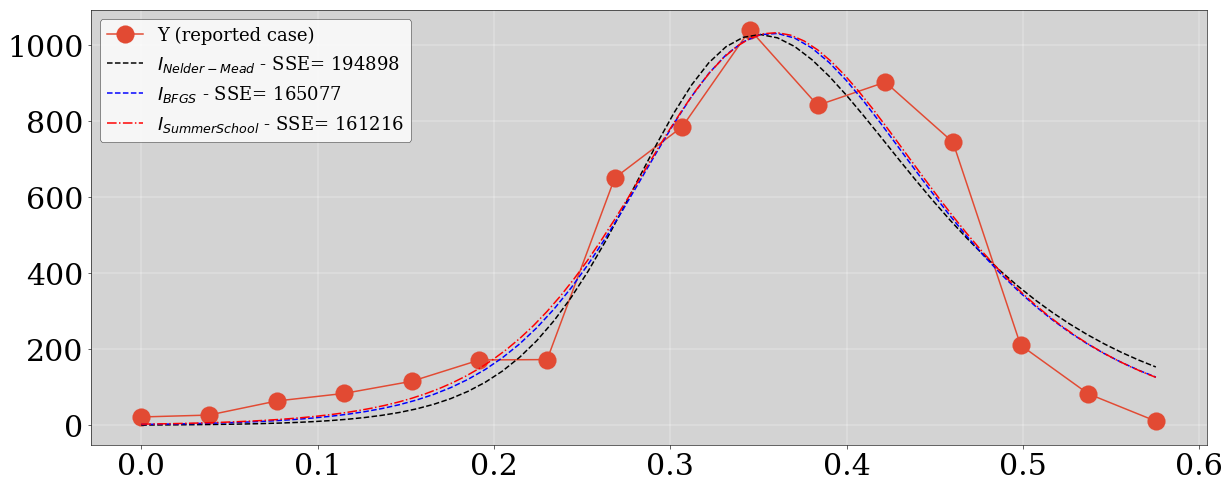

In [23]:
### Case count
Y=df2.V1
t_Y=(df2.index-1)*(14/365)


#############
####################
##############################

###### Nelder-Mead. results
beta,gamma,s0,i0,r0=res_Nelder_Mead.x

# Overridden Values
r0=0
#gamma=365/13

t_end=(df2.V1.index[-1]-1)*(14/365)
T=np.linspace(0,t_end,60)

initial_state=[s0,i0,r0]
sol = odeint(SIR, initial_state,T,args=(beta,gamma))
S=sol[:,0]
I=sol[:,1]
R=sol[:,2]

sse1=int(res_Nelder_Mead.fun)


###############
#################
####################


###### BFGS. results
beta,gamma,s0,i0,r0=res_BFGS.x

# Overridden Values
r0=0
#gamma=365/13

t_end=(df2.V1.index[-1]-1)*(14/365)
T2=np.linspace(0,t_end,60)

initial_state=[s0,i0,r0]
sol = odeint(SIR, initial_state,T2,args=(beta,gamma))
S2=sol[:,0]
I2=sol[:,1]
R2=sol[:,2]

sse2=int(res_BFGS.fun)


###############
#################
####################



# Summer School Result

beta=4.270174e-3
gamma=35.14039
s_initial=1.306079e4
i_initial=3.109724
r_initial=0

dt3=(14/365)*0.2
T3=np.arange(0,t_end+dt3,dt3)

initial_state=[s_initial,i_initial,r_initial]
sol = odeint(SIR, initial_state,T3,args=(beta,gamma))
S3=sol[:,0]
I3=sol[:,1]
R3=sol[:,2]


diff=Y-np.interp(t_Y,T3,I3)
sse3=int(sum(diff**2))

#############
###################
###########################

#### Plots

fig=plt.figure(figsize=(20,8))
ax=plt.subplot(111)
plt.plot(t_Y,Y,marker='o',label='Y (reported case)')
plt.plot(T,I,'--k',label='$I_{Nelder-Mead}$ - SSE= '+str(sse1))
plt.plot(T2,I2,'--b',label='$I_{BFGS}$ - SSE= '+str(sse2))
plt.plot(T3,I3,'-.r',label='$I_{Summer School}$ - SSE= '+str(sse3))
plt.legend(fontsize=18)

# Log-likelihood 

In [107]:
def MLE_obj(params,Y,PDF):
    beta,gamma,s0,i0,r0=params
    t_Y=(Y.index.values-1)*(14/365)
    
    if any(params<0):
        LL=1e9
        return LL
    #### Overridden values
    r0=0
    #gamma=365/13
    
    n=len(Y)
    
    t_end=(Y.index[-1]-1)*(14/365)
    dt=(14/365)*0.2
    T=np.linspace(0,t_end,n)

    initial_state=[s0,i0,r0]
    sol = odeint(SIR, initial_state,T,args=(beta,gamma))
    I=sol[:,1]
    
    if PDF=='Normal': 
        diff=Y-np.interp(t_Y,T,I)
        sse=sum(diff**2)
        variance=sse/n
        LL=-(-(n/2)*np.log(2*pi*variance)-n/2)
    elif PDF=='Poisson':
        I_i=np.interp(t_Y,T,I)
        #LL=1.0
        for i in range(n):
            LL=sum(Y.values*np.log(I_i))
            LL=LL-sum(I_i)
            
        LL=-LL
        
            
    return LL  

In [132]:
beta=0.04076
gamma=365/13
s0=1480
i0=1
r0=0.0
initial=[beta,gamma,s0,i0,r0]


MLE_normal=minimize(MLE_obj,initial,args=(df2.V1,'Normal'),method="Nelder-Mead",options={'maxiter': 40000,'maxfev':40000,'fatol':0.001},tol=0.001)
MLE_poisson=minimize(MLE_obj,initial,args=(df2.V1,'Poisson'),method="Nelder-Mead",options={'maxiter': 40000,'maxfev':40000,'fatol':0.001},tol=0.001)

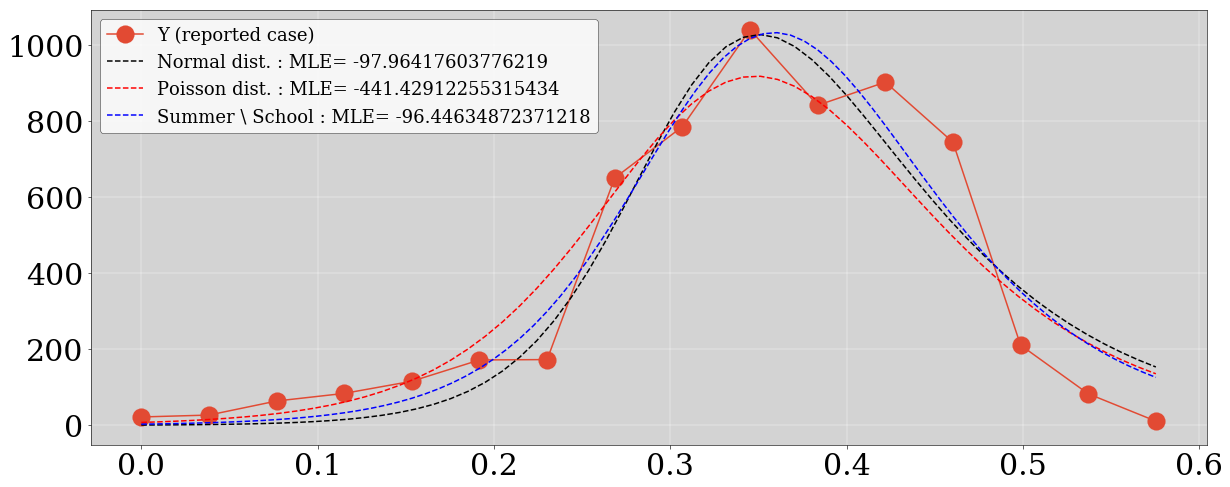

In [134]:
###### Normal dist. results
beta,gamma,s0,i0,r0=MLE_normal.x

# Overridden Values
r0=0


t_end=(df2.V1.index[-1]-1)*(14/365)
T=np.linspace(0,t_end,60)

initial_state=[s0,i0,r0]
sol1 = odeint(SIR, initial_state,T,args=(beta,gamma))
S1=sol1[:,0]
I1=sol1[:,1]
R1=sol1[:,2]

MLE1=-MLE_normal.fun


###############
#################
####################


###### Poisson dist. results
beta,gamma,s0,i0,r0=MLE_poisson.x

# Overridden Values
r0=0

t_end=(df2.V1.index[-1]-1)*(14/365)
T=np.linspace(0,t_end,60)

initial_state=[s0,i0,r0]
sol2 = odeint(SIR, initial_state,T,args=(beta,gamma))
S2=sol2[:,0]
I2=sol2[:,1]
R2=sol2[:,2]


t_Y=(Y.index.values-1)*(14/365)
I_i=np.interp(t_Y,T,I2)

temp1=list()
for i in range(n):
    temp1.append(poisson.pmf(Y.values[i],I_i[i]))
MLE2=np.prod(temp1)
MLE2=np.log(MLE2)
#LE2=MLE_poisson.fun


###############
#################
####################

# Summer School Result

beta=4.270174e-3
gamma=35.14039
s_initial=1.306079e4
i_initial=3.109724
r_initial=0

dt2=(14/365)*0.2
T2=np.arange(0,t_end+dt2,dt2)

initial_state=[s_initial,i_initial,r_initial]
sol = odeint(SIR, initial_state,T2,args=(beta,gamma))
S=sol[:,0]
I=sol[:,1]
R=sol[:,2]

n=len(Y)
diff=Y-np.interp(t_Y,T2,I)
sse=sum(diff**2)
variance=sse/n
MLE3=-(n/2)*np.log(2*pi*variance)-n/2



#### Plots

fig=plt.figure(figsize=(20,8))
ax=plt.subplot(111)
plt.plot(t_Y,Y,marker='o',label='Y (reported case)')
plt.plot(T,I1,'--k',label='Normal dist. : MLE= '+str(MLE1))
plt.plot(T,I2,'--r',label='Poisson dist. : MLE= '+str(MLE2))
plt.plot(T2,I,'--b',label='Summer \\ School : MLE= '+str(MLE3))

plt.legend(fontsize=18)

-441.42912255315434

 final_simplex: (array([[1.02360821e-02, 1.58949211e+01, 4.08074447e+03, 7.83048633e-01,
        1.07929844e-13],
       [1.02360835e-02, 1.58949250e+01, 4.08074500e+03, 7.83046928e-01,
        3.58244899e-13],
       [1.02360806e-02, 1.58949171e+01, 4.08074397e+03, 7.83050306e-01,
        2.24012338e-13],
       [1.02360847e-02, 1.58949242e+01, 4.08074392e+03, 7.83049451e-01,
        6.67331446e-14],
       [1.02360822e-02, 1.58949200e+01, 4.08074399e+03, 7.83049860e-01,
        2.96155357e-13],
       [1.02360826e-02, 1.58949209e+01, 4.08074405e+03, 7.83049615e-01,
        3.36130819e-13]]), array([97.96417604, 97.96417604, 97.96417604, 97.96417604, 97.96417604,
       97.96417604]))
           fun: 97.96417603776219
       message: 'Optimization terminated successfully.'
          nfev: 716
           nit: 426
        status: 0
       success: True
             x: array([1.02360821e-02, 1.58949211e+01, 4.08074447e+03, 7.83048633e-01,
       1.07929844e-13])